In [61]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load data
file_path = '/Users/benwong/Documents/Y3S2/dse4211/dse4211 grp project/dataset/processed_data.csv'
df = pd.read_csv(file_path)
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df.dropna(subset=["date"], inplace=True)
df.set_index("date", inplace=True)
df.dropna(inplace=True)

# Settings
assets = df["ticker"].unique()
VALIDATION_START = "2024-01-01"
VALIDATION_END = "2024-12-31"
TEST_START = "2025-01-01"
TEST_END = "2025-02-28"
features = ["sma_50", "volatility_30", "macd", "macd_signal", "macd_histogram",
            "bollinger_upper", "bollinger_lower", "bollinger_bandwidth",
            "rsi_14", "atr_14", "momentum_5", "volume_ma_5", "stoch_d_14"]

# Cache asset data
asset_data_map = {asset: df[df["ticker"] == asset].copy() for asset in assets}

# Model training
performance = {}
models = {}
for asset in assets:
    df_asset = asset_data_map[asset]
    df_asset["Close_Next_Day"] = df_asset["close"].shift(-1)
    df_asset.dropna(inplace=True)

    validation_data = df_asset[(df_asset.index >= VALIDATION_START) & (df_asset.index <= VALIDATION_END)]
    test_data = df_asset[(df_asset.index >= TEST_START) & (df_asset.index <= TEST_END)]

    X_train = validation_data[features]
    y_train = validation_data["Close_Next_Day"]
    X_test = test_data[features]
    y_test = test_data["Close_Next_Day"]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    models[asset] = model

    importances = model.feature_importances_
    feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
    print(f"\n{asset} Feature Importance:\n{feature_importance}")

    if not X_test.empty and not y_test.empty:
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        performance[asset] = {"MAE": mae}
        print(f"{asset} Test Period MAE: {mae:.2f}")
    else:
        print(f"No test data available for {asset}. Skipping evaluation...")

performance_df = pd.DataFrame.from_dict(performance, orient="index")
performance_df.to_csv("model_performance.csv")
print("Performance results saved.")


BND Feature Importance:
sma_50                 0.572955
bollinger_upper        0.235387
macd_signal            0.089845
macd                   0.052002
bollinger_lower        0.019575
momentum_5             0.006365
macd_histogram         0.005720
rsi_14                 0.004533
atr_14                 0.004231
volume_ma_5            0.003445
bollinger_bandwidth    0.002651
stoch_d_14             0.001766
volatility_30          0.001525
dtype: float64
BND Test Period MAE: 0.51

BTC-USD Feature Importance:
bollinger_upper        0.786854
sma_50                 0.142269
macd                   0.038173
bollinger_lower        0.009648
momentum_5             0.003795
atr_14                 0.003317
rsi_14                 0.002723
stoch_d_14             0.002676
macd_histogram         0.002646
bollinger_bandwidth    0.002201
volume_ma_5            0.002098
volatility_30          0.002023
macd_signal            0.001577
dtype: float64
BTC-USD Test Period MAE: 3807.08

GLD Feature Importance:


In [43]:
# Simulated Trading Strategy
initial_cash = 1_000_000
portfolio = {asset: 0 for asset in assets}
portfolio["cash"] = initial_cash
highest_price = {asset: 0 for asset in assets}
TRADE_THRESHOLD = 0.5
TRAILING_STOP_LOSS = -1
trade_log = []
portfolio_values = []

for date in pd.date_range(TEST_START, TEST_END):
    predicted_prices_today = {}
    for asset in assets:
        asset_data = asset_data_map[asset]
        if date not in asset_data.index:
            continue
        row = asset_data.loc[[date]]
        if row[features].isnull().values.any():
            continue
        try:
            predicted_price = models[asset].predict(row[features])[0]
            predicted_prices_today[asset] = predicted_price
        except:
            continue

    # BUY logic
    buy_candidates = []
    for asset in assets:
        asset_data = asset_data_map[asset]
        if date not in asset_data.index or asset not in predicted_prices_today:
            continue
        actual_price = asset_data.loc[date, "close"]
        predicted_price = predicted_prices_today[asset]
        expected_return = ((predicted_price - actual_price) / actual_price) * 100
        print(f"{date} | {asset} | Actual: {actual_price:.2f} | Predicted: {predicted_price:.2f} | Predicted_return: {expected_return:.4f}%")
        if expected_return > TRADE_THRESHOLD and portfolio["cash"] > actual_price and portfolio[asset] == 0:
            buy_candidates.append((expected_return, asset, actual_price, predicted_price))

    buy_candidates.sort(reverse=True, key=lambda x: x[0])
    for expected_return, asset, actual_price, predicted_price in buy_candidates:
        if portfolio["cash"] < actual_price:
            break
        quantity = round(0.98 * portfolio["cash"] / actual_price, 6)
        buy_fee = round(max(quantity * 0.005, 1.0), 2)
        portfolio[asset] += quantity
        portfolio["cash"] -= quantity * actual_price + buy_fee
        highest_price[asset] = actual_price
        trade_log.append((date, "BUY", asset, quantity, actual_price, buy_fee))
        print(f"{date}: BUY {quantity:.6f} {asset} at ${actual_price:.2f} (Expected Return: {expected_return:.2f}%)")

    # SELL logic
    for asset in assets:
        if portfolio[asset] == 0:
            continue
        asset_data = asset_data_map[asset]
        if date not in asset_data.index:
            continue
        actual_price = asset_data.loc[date, "close"]
        current_pred = predicted_prices_today.get(asset)
        if actual_price > highest_price[asset]:
            highest_price[asset] = actual_price
        for other_asset, other_pred in predicted_prices_today.items():
            if other_asset == asset or portfolio[other_asset] > 0:
                continue
            if date not in asset_data_map[other_asset].index:
                continue
            other_actual = asset_data_map[other_asset].loc[date, "close"]
            if (other_pred - other_actual) / other_actual > (current_pred - actual_price) / actual_price:
                quantity = portfolio[asset]
                sell_fee = round(max(quantity * 0.005, 1.0), 2)
                portfolio["cash"] += quantity * actual_price - sell_fee
                portfolio[asset] = 0
                trade_log.append((date, "SELL", asset, round(quantity, 6), actual_price, sell_fee))
                print(f"{date}: SELL {quantity:.6f} {asset} at ${actual_price:.2f} (Switch to better asset: {other_asset})")
                break
        price_drop = ((actual_price - highest_price[asset]) / highest_price[asset]) * 100
        if price_drop < TRAILING_STOP_LOSS:
            quantity = portfolio[asset]
            sell_fee = round(max(quantity * 0.005, 1.0), 2)
            portfolio["cash"] += quantity * actual_price - sell_fee
            portfolio[asset] = 0
            trade_log.append((date, "SELL", asset, round(quantity, 6), actual_price, sell_fee))
            print(f"{date}: SELL {quantity:.6f} {asset} at ${actual_price:.2f} (Trailing Stop Triggered)")

    daily_value = portfolio["cash"]
    for asset in assets:
        asset_data = asset_data_map[asset]
        asset_data = asset_data[asset_data.index <= date]
        if not asset_data.empty:
            last_price = asset_data.iloc[-1]["close"]
            daily_value += portfolio[asset] * last_price
    portfolio_values.append((date, daily_value))

2025-01-01 00:00:00 | BTC-USD | Actual: 94419.76 | Predicted: 95214.88 | Predicted_return: 0.8421%
2025-01-01 00:00:00: BUY 10.379184 BTC-USD at $94419.76 (Expected Return: 0.84%)
2025-01-02 00:00:00 | BND | Actual: 71.49 | Predicted: 71.44 | Predicted_return: -0.0722%
2025-01-02 00:00:00 | BTC-USD | Actual: 96886.88 | Predicted: 96511.49 | Predicted_return: -0.3874%
2025-01-02 00:00:00 | GLD | Actual: 245.42 | Predicted: 245.92 | Predicted_return: 0.2019%
2025-01-02 00:00:00 | QQQM | Actual: 210.05 | Predicted: 212.17 | Predicted_return: 1.0110%
2025-01-02 00:00:00 | SCHV | Actual: 25.99 | Predicted: 26.11 | Predicted_return: 0.4441%
2025-01-02 00:00:00: BUY 93.306265 QQQM at $210.05 (Expected Return: 1.01%)
2025-01-02 00:00:00: SELL 10.379184 BTC-USD at $96886.88 (Switch to better asset: BND)
2025-01-03 00:00:00 | BND | Actual: 71.40 | Predicted: 71.44 | Predicted_return: 0.0506%
2025-01-03 00:00:00 | BTC-USD | Actual: 98107.43 | Predicted: 96759.53 | Predicted_return: -1.3739%
2025-

In [59]:
# Save trade log
trade_df = pd.DataFrame(trade_log, columns=["date", "action", "asset", "quantity", "price", "transactionfees"])
trade_df.to_csv("trade_log.csv", index=False)
print("Trade log saved to trade_log.csv")

Trade log saved to trade_log.csv


In [51]:
# Final Portfolio Summary
portfolio_df = pd.DataFrame(portfolio_values, columns=["date", "portfolio_value"])
portfolio_df.set_index("date", inplace=True)
final_value = portfolio_df["portfolio_value"].iloc[-1]
roi = (final_value - initial_cash) / initial_cash * 100
print(f"\nFinal Portfolio Value: ${final_value:.2f}")
print(f"ROI: {roi:.2f}%")


Final Portfolio Value: $1077526.91
ROI: 7.75%


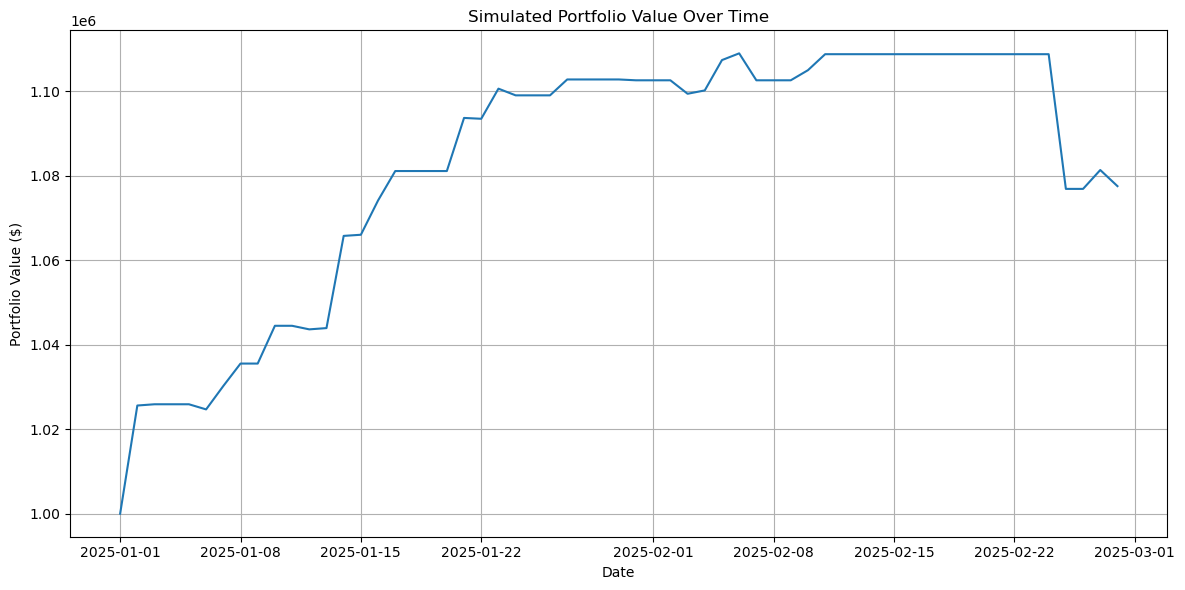

In [53]:
# Portfolio value plot
portfolio_df = pd.DataFrame(portfolio_values, columns=["date", "portfolio_value"])
portfolio_df.set_index("date", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df["portfolio_value"])
plt.title("Simulated Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


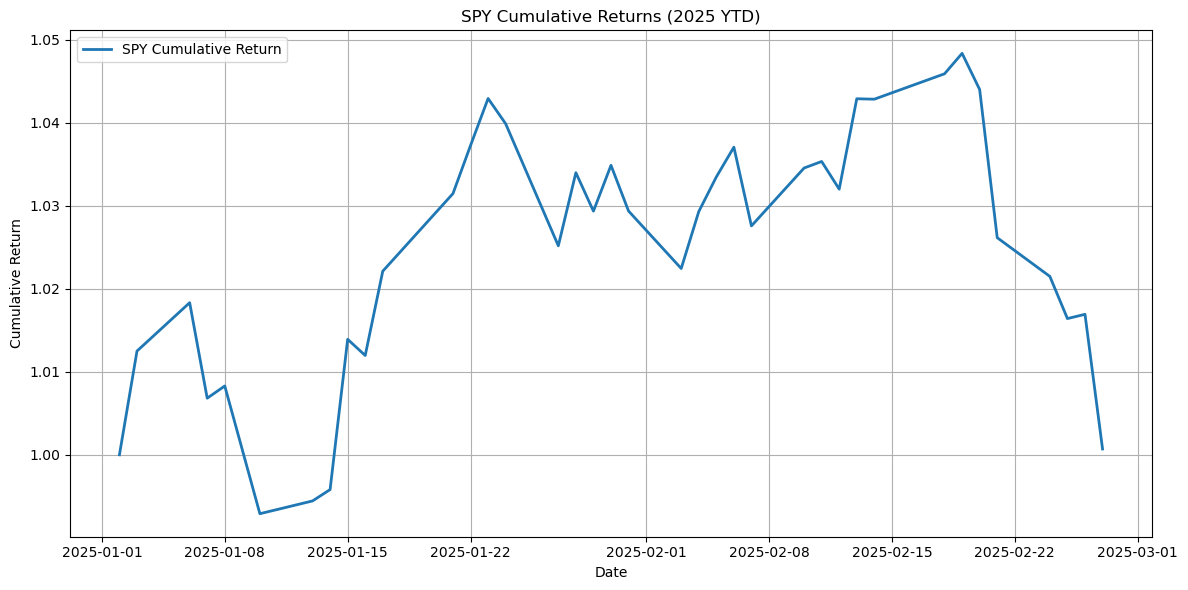

Pct Change of SPY YTD is 0.07012%.


In [55]:
# Comparison to benchmark returns for SPY
import yfinance as yf
spy_data = yf.download("SPY" , start = "2025-01-01", end = "2025-02-28", auto_adjust = True) #can amend the start and end date accordingly
#Plot daily cumulative returns of SPY until now
spy_data['Daily_return'] = (spy_data['Close'].pct_change()).fillna(0)
spy_data["cumulative_return"] = (1 + spy_data["Daily_return"]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(spy_data.index, spy_data["cumulative_return"], label="SPY Cumulative Return", linewidth=2)
plt.title("SPY Cumulative Returns (2025 YTD)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pct Change of SPY YTD is " + str(round((spy_data["cumulative_return"].iloc[-1] - 1) * 100, 5)) + "%.")

In [57]:
from sklearn.linear_model import LinearRegression
# Prep
portfolio_df = portfolio_df.copy()
portfolio_df['returns'] = portfolio_df['portfolio_value'].pct_change().fillna(0)
portfolio_df['cumulative'] = (1 + portfolio_df['returns']).cumprod()

# Special case for beta to make it aligned // removal of additional data for our portfolio that has emerged due to 24/7 trading of crypto 
# more advisable compared to forward filling
spy_returns = spy_data[["Daily_return"]].copy()
portfolio_returns = portfolio_df[["returns"]].copy()

# Inner join on common dates
combined_df = pd.concat([portfolio_returns, spy_returns], axis=1, join='inner')
combined_df.columns = ['portfolio_returns', 'spy_returns']

# Max Drawdown
def max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1
    return drawdown.min()

# Sharpe Ratio (Assuming risk-free rate = 0)
def sharpe_ratio(returns, risk_free_rate_annual=0.0435, periods_per_year=252):
    daily_rf = risk_free_rate_annual / periods_per_year
    excess_returns = returns - daily_rf
    return (excess_returns.mean() / returns.std()) * np.sqrt(periods_per_year)
    
# Annualized Volatility
def annualized_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

# Beta
def calculate_beta(portfolio_returns, market_returns):
    X = market_returns.values.reshape(-1, 1)
    y = portfolio_returns.values
    reg = LinearRegression().fit(X, y)
    return reg.coef_[0]

# Portfolio metrics
portfolio_max_dd = max_drawdown(portfolio_df['cumulative'])
portfolio_sharpe = sharpe_ratio(portfolio_df['returns'])
portfolio_vol = annualized_volatility(portfolio_df['returns'])
portfolio_beta = calculate_beta(combined_df['portfolio_returns'], combined_df['spy_returns'])

# SPY metrics
spy_max_dd = max_drawdown(spy_data['cumulative_return'])
spy_sharpe = sharpe_ratio(spy_data['Daily_return'])
spy_vol = annualized_volatility(spy_data['Daily_return'])
spy_beta = 1.0  # Benchmark

# Output
print("PORTFOLIO METRICS")
print(f"Max Drawdown: {portfolio_max_dd:.2%}")
print(f"Sharpe Ratio: {portfolio_sharpe:.4f}")
print(f"Annualized Volatility: {portfolio_vol:.2%}")
print(f"Beta: {portfolio_beta:.4f}")
print("\nSPY METRICS")
print(f"Max Drawdown: {spy_max_dd:.2%}")
print(f"Sharpe Ratio: {spy_sharpe:.4f}")
print(f"Annualized Volatility: {spy_vol:.2%}")
print(f"Beta: {spy_beta:.4f}")

PORTFOLIO METRICS
Max Drawdown: -2.89%
Sharpe Ratio: 2.7614
Annualized Volatility: 10.17%
Beta: 0.0769

SPY METRICS
Max Drawdown: -4.55%
Sharpe Ratio: -0.2347
Annualized Volatility: 13.03%
Beta: 1.0000
